# Earl R2D2 demo

This notebook will train an [R2D2](https://openreview.net/forum?id=r1lyTjAqYX) agent on two very similar environments using the two different environment loops which implement the two [Podracer architectures](https://arxiv.org/abs/2104.06272).

We will train an agent on the Atari game "Asterix".

In [1]:
%load_ext autoreload
%autoreload 1
%aimport earl.agents.r2d2.networks
%aimport earl.agents.r2d2.r2d2
%aimport earl.agents.r2d2.utils
%aimport earl.core

In [2]:
import io
import math
import time

import gymnasium
import jax
import jax.numpy as jnp
from IPython.display import Image
from jax_loop_utils.metric_writers._audio_video import encode_video_to_gif
from jax_loop_utils.metric_writers.async_writer import AsyncWriter
from jax_loop_utils.metric_writers.memory_writer import MemoryWriter
from jax_loop_utils.metric_writers.torch import TensorboardWriter

import earl.agents.r2d2.networks as r2d2_networks
from earl.agents.r2d2 import utils
from earl.agents.r2d2.r2d2 import R2D2, R2D2Config
from earl.core import env_info_from_gymnasium, env_info_from_gymnax
from earl.environment_loop.gymnasium_loop import GymnasiumLoop
from earl.environment_loop.gymnax_loop import GymnaxLoop


## Gymnax (Anakin)  

GymnaxLoop is for Anakin-style training, meaning the environment is jax.jit-compatible and runs on the same device as the learning.

We will use an implementation of Asterix in JAX that has simplified graphics.


### init environment

In [3]:
import gymnax.environments.spaces
from gymnax.environments.minatar.asterix import MinAsterix

env = MinAsterix()
num_envs = 512
env_params = env.default_params
env_info = env_info_from_gymnax(env, env_params, num_envs)
action_space = env.action_space(env_params)
assert isinstance(action_space, gymnax.environments.spaces.Discrete), action_space
num_actions = int(action_space.n)
observation_space = env.observation_space(env_params)
assert isinstance(observation_space, gymnax.environments.spaces.Box), observation_space


### init networks and agent

In [6]:
hidden_size = 64
key = jax.random.PRNGKey(0)
networks_key, loop_key, agent_key = jax.random.split(key, 3)
networks = r2d2_networks.make_networks_mlp(
    num_actions=num_actions,
    input_size=int(math.prod(observation_space.shape)),
    dtype=jnp.float32,
    hidden_size=hidden_size,
    key=networks_key,
)
num_cycles = 5_500
steps_per_cycle = 80
devices = jax.local_devices()
print(f"running on {len(devices)} {devices[0].platform} devices")
config = R2D2Config(
    epsilon_greedy_schedule_args=dict(
      init_value=0.9, end_value=0.01, transition_steps=steps_per_cycle * 1_000
    ),
    num_envs_per_learner=num_envs,
    replay_seq_length=steps_per_cycle,
    buffer_capacity=steps_per_cycle * 10,
    burn_in=40,
    learning_rate_schedule_name="cosine_onecycle_schedule",
    learning_rate_schedule_args=dict(
      transition_steps=steps_per_cycle * 2_500,
      # NOTE: more devices effectively means a larger batch size, so we
      # scale the learning rate up to train faster!
      peak_value=5e-5 * len(devices),
    ),
    target_update_step_size=0.00,
    target_update_period=500,
)
agent = R2D2(env_info, config)
loop_state = agent.new_state(networks, agent_key)


running on 2 gpu devices


### run one cycle in actor_only mode to gather video

run in `actor_only` and pass `observe_cycle` to render a video of initial performance

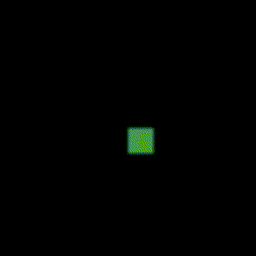

In [7]:
metric_writer = MemoryWriter()
eval_loop = GymnaxLoop(
    env,
    env_params,
    agent,
    num_envs,
    loop_key,
    actor_only=True,
    observe_cycle=utils.render_minatar_cycle,
    metric_writer=metric_writer,
    devices=devices,
)
loop_state = eval_loop.run(loop_state, 1, 2*steps_per_cycle)
video_buf = io.BytesIO()
video_array = next(iter(metric_writer.videos.values()))['video']
video_array = jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    video_array, (256, 256, 3), "bilinear").astype(jnp.uint8)
encode_video_to_gif(video_array, video_buf)
Image(video_buf.getvalue())

### train

In [29]:
%load_ext tensorboard
%tensorboard --logdir logs


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2661613), started 17:41:05 ago. (Use '!kill 2661613' to kill it.)

In [8]:
metric_writer = AsyncWriter(TensorboardWriter(logdir="logs/MinAsterix"))
train_loop = GymnaxLoop(
    env,
    env_params,
    agent,
    num_envs,
    loop_key,
    metric_writer=metric_writer,
    devices=devices,
)
training_start_time = time.monotonic()
loop_state = train_loop.run(loop_state, num_cycles, steps_per_cycle)


In [9]:
elapsed_time = time.monotonic() - training_start_time
print(f"Training took {elapsed_time:.2f} seconds")
total_env_steps = steps_per_cycle * num_cycles * num_envs * len(devices)
print(f"steps per second: {total_env_steps / elapsed_time:.2f}")
total_learner_updates = (
    num_cycles * len(devices) * config.num_off_policy_optims_per_cycle)
print(f"learner updates per second: {total_learner_updates / elapsed_time :.2f}")


Training took 1014.32 seconds
steps per second: 444200.70
learner updates per second: 108.45


### run one cycle to gather video

We can also write the video to tensorboard instead of in memory.

Once the cell below runs, the video will show up in the Images tab of Tensorboard.

cycles:   0%|          | 0/1 [00:00<?, ?cycle/s]

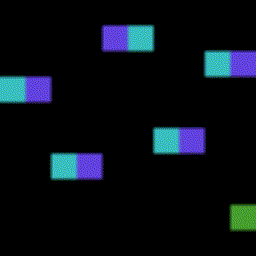

In [12]:
metric_writer = MemoryWriter()
eval_loop = GymnaxLoop(
    env,
    env_params,
    agent,
    num_envs,
    loop_key,
    actor_only=True,
    observe_cycle=utils.render_minatar_cycle,
    metric_writer=metric_writer,
    devices=devices,
)
loop_state = eval_loop.run(loop_state, 1, 4 * steps_per_cycle)
video_buf = io.BytesIO()
video_array = next(iter(metric_writer.videos.values()))['video']
video_array = jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    video_array, (256, 256, 3), "bilinear").astype(jnp.uint8)
encode_video_to_gif(video_array, video_buf)
Image(video_buf.getvalue())

## Gymnasium (Sebulba)  

GymnaxLoop is for Sebulba-style training, meaning the environment is *not* jax.jit-compatible and we have separate actor and learner devices.

We will train on the actual Atari game Asterix using the Arcade Learning Environment.

In [7]:
import functools

import envpool

### init environment

In [10]:
devices = jax.local_devices()
if len(devices) > 1:
    actor_devices = devices[: max(1, len(devices) // 3)]
    learner_devices = devices[len(actor_devices) :]
else:
    actor_devices = devices
    learner_devices = devices
num_envs = 32
num_envs_per_learner = num_envs // len(learner_devices)
print(f"num_envs: {num_envs}")
stack_num = 2
input_size = (64, 64)
env_factory = functools.partial(
    envpool.make_gymnasium,
    "Asterix-v5",
    num_envs=num_envs,
    stack_num=stack_num,
    img_height=input_size[0],
    img_width=input_size[1],
)
env = env_factory()
assert isinstance(env.action_space, gymnasium.spaces.Discrete)
num_actions = int(env.action_space.n)
env.close()
print(f"running on {len(actor_devices)} actor devices and {len(learner_devices)} learner devices")
if actor_devices == learner_devices:
    print("WARNING: actor and learner devices are the same. They will compete for the devices.")
env_info = env_info_from_gymnasium(env, num_envs)
del env

num_envs: 32
running on 1 actor devices and 1 learner devices


### init networks and agent

In [32]:
hidden_size = 512
key = jax.random.PRNGKey(0)
networks_key, loop_key, agent_key = jax.random.split(key, 3)
networks = r2d2_networks.make_networks_resnet(
  num_actions=num_actions,
  in_channels=stack_num,
  hidden_size=hidden_size,
  key=networks_key,
  input_size=input_size,
)
steps_per_cycle = 48

config = R2D2Config(
  epsilon_greedy_schedule_args=dict(
    init_value=0.9, end_value=0.01, transition_steps=steps_per_cycle * 1_000
  ),
  num_envs_per_learner=num_envs_per_learner,
  replay_seq_length=steps_per_cycle,
  replay_batch_size=64,
  buffer_capacity=steps_per_cycle * 10,
  burn_in=16,
  learning_rate_schedule_name="cosine_onecycle_schedule",
  learning_rate_schedule_args=dict(
    transition_steps=steps_per_cycle * 5_000,
    # NOTE: more devices effectively means a larger batch size, so we
    # scale the learning rate up to train faster!
    peak_value=1e-5 * len(learner_devices),
  ),
  target_update_step_size=0.00,
  target_update_period=1_000,
  num_off_policy_optims_per_cycle=1,
)
agent = R2D2(env_info, config)
loop_state = agent.new_state(networks, agent_key)

### run one cycle in actor_only mode to gather video

run in `actor_only` and pass `observe_cycle` to render a video of initial performance

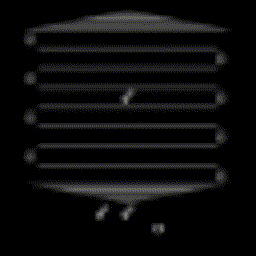

In [33]:
metric_writer = MemoryWriter()
eval_loop = GymnasiumLoop(
    env_factory,
    agent,
    num_envs,
    loop_key,
    actor_only=True,
    observe_cycle=utils.render_atari_cycle,
    metric_writer=metric_writer,
    actor_devices=actor_devices,
    learner_devices=learner_devices,
    vectorization_mode="none",
)
loop_state = eval_loop.run(loop_state, 1, 4*steps_per_cycle)
video_buf = io.BytesIO()
video_array = next(iter(metric_writer.videos.values()))['video']
video_array = jax.vmap(jax.image.resize, in_axes=(0, None, None))(
    video_array, (256, 256, 1), "bilinear").astype(jnp.uint8)
encode_video_to_gif(video_array, video_buf)
Image(video_buf.getvalue())

In [34]:
eval_loop.close()

### train

In [35]:
metric_writer = AsyncWriter(TensorboardWriter(logdir="logs/Asterix"))
num_cycles = 10_000
train_loop = GymnasiumLoop(
    env_factory,
    agent,
    num_envs,
    loop_key,
    metric_writer=metric_writer,
    actor_devices=actor_devices,
    learner_devices=learner_devices,
    vectorization_mode="none",
)
training_start_time = time.monotonic()
loop_state = train_loop.run(loop_state, num_cycles, steps_per_cycle)


cycles:   0%|          | 0/10000 [00:00<?, ?cycle/s]

In [36]:
elapsed_time = time.monotonic() - training_start_time
print(f"Training took {elapsed_time:.2f} seconds")
total_env_steps = steps_per_cycle * num_cycles * num_envs * 2 * len(actor_devices)
print(f"steps per second: {total_env_steps / elapsed_time:.2f}")
total_learner_updates = (
    num_cycles * len(learner_devices) * config.num_off_policy_optims_per_cycle)
print(f"learner updates per second: {total_learner_updates / elapsed_time :.2f}")

Training took 3142.24 seconds
steps per second: 9776.47
learner updates per second: 3.18


### Note

I haven't had time to run GymnasiumLoop long enough and do the necessary hyperparemeter tuning to get a good agent out of it yet, so not including a video here for now.